# Generate sample explanations and get metric values

In [1]:
import torchvision
import torch
import numpy as np
import matplotlib.pyplot as plt
from autoexplainer.explanations.custom import grad_cam
from autoexplainer.utils import fix_relus_in_model, torch_image_to_numpy_image, normalize_image
import quantus
from functools import partial

import tqdm

## Parameters

1. `BATCH_SIZE_PER_CLASS` - Number of images to be analyzed from each class, minimum 2.
2. `MAX_NUM_OF_CLASSES_ANALYZED` - Number of classes to be analyzed. In case of ImageNette, there are 10 classes and that would take a bit too long to analyze 2 images from 10 classes.

In [2]:
# general parameters
BATCH_SIZE_PER_CLASS = 2
MAX_NUM_OF_CLASSES_ANALYZED = 3

# specific parameters
DATASET = "Imagenette"
DATASET_PATH = "../../data/imagenette/"
MODEL_PATH = "../../models/chosen_model_imagenette_pretrained_097.pth"

In [3]:
# model and dataset
model = torch.load(MODEL_PATH, map_location='cpu')
model = fix_relus_in_model(model)
transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((256, 256)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
dataset = torchvision.datasets.ImageFolder(DATASET_PATH, transform=transform)
number_of_classes = len(dataset.classes)

In [4]:
# explanations
explanation_functions = {
    "IntegratedGradients" : partial(quantus.explain, method="IntegratedGradients", normalise=True),
    "Saliency" : partial(quantus.explain, method="Saliency", normalise=True),
    "grad_cam" : grad_cam,
}

In [5]:
# metrics
metric_functions = {
    "FaithfulnessEstimate" : quantus.FaithfulnessEstimate(
        **{
            "perturb_func": quantus.baseline_replacement_by_indices,
            "similarity_func": quantus.correlation_pearson,
            "features_in_step": 256,
            "perturb_baseline": "mean",
            "pixels_in_step": 28,
        }
    ),
    "FaithfulnessCorrelation" : quantus.FaithfulnessCorrelation(
        **{
            "nr_runs": 10,
            "subset_size": 224,
            "perturb_baseline": "mean",
            "perturb_func": quantus.baseline_replacement_by_indices,
            "similarity_func": quantus.correlation_pearson,
            "return_aggregate": False,
        }
    ),
    "MaxSensitivity" : quantus.MaxSensitivity(
        **{
            "nr_samples": 2,  # mały sample aby szybko działało, potem warto go zwiększyć
            "perturb_radius": 0.2,
            "norm_numerator": quantus.fro_norm,
            "norm_denominator": quantus.fro_norm,
            "perturb_func": quantus.uniform_noise,
            "similarity_func": quantus.difference,
        }
    ),
    "Complexity" : quantus.Complexity(),
    "RandomLogit" : quantus.RandomLogit(
        **{
            "num_classes": number_of_classes,
            "similarity_func": quantus.ssim,
        }
    ),
    "IterativeRemovalOfFeatures" : quantus.IterativeRemovalOfFeatures(
        **{
            "segmentation_method": "slic",
            "perturb_baseline": "mean",
            "perturb_func": quantus.baseline_replacement_by_indices,
            "return_aggregate": False,
        }
    ),
    "AvgSensitivity" : quantus.AvgSensitivity(
        **{
            "nr_samples": 2,  # mały sample aby szybko działało, potem warto go zwiększyć
            "perturb_radius": 0.2,
            "norm_numerator": quantus.fro_norm,
            "norm_denominator": quantus.fro_norm,
            "perturb_func": quantus.uniform_noise,
            "similarity_func": quantus.difference,
        }
    ),
    "Sparseness" : quantus.Sparseness(),
}

Warnings and information:
 (1) The Faithfulness Estimate metric is likely to be sensitive to the choice of baseline value 'perturb_baseline' and similarity function 'similarity_func'. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Alvarez-Melis, David, and Tommi S. Jaakkola. 'Towards robust interpretability with self-explaining neural networks.' arXiv preprint arXiv:1806.07538 (2018).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.

Warnings and information:
 (1) The Faithfulness Correlation metric is likely to be sensitive to the choice of baseline value 'perturb_baseline', size of subset |S| 'subset_size' and the number of runs (for e

In [6]:
# helpers
def get_attributions_for_batch(model, batch_x, batch_y):
    attributions = {
        explanation_name : explanation_function(model, batch_x, batch_y)
        for explanation_name, explanation_function in explanation_functions.items()
    }
    return attributions

def plot_attributions_for_batch(batch_x, batch_y, attributions):
    fig, axs = plt.subplots(BATCH_SIZE_PER_CLASS, len(attributions)+1, figsize=(BATCH_SIZE_PER_CLASS*13, len(attributions)))
    for j in range(BATCH_SIZE_PER_CLASS):    
        axs[j, 0].imshow(normalize_image(torch_image_to_numpy_image(batch_x[j])))
        axs[j, 0].set_title(f"original image, class {batch_y[j]}", fontsize=14)
        for i, (explanation_name, explanation) in enumerate(attributions.items()):
            if explanation.shape[1] == 256:
                axs[j, i+1].imshow(explanation[j])
            else:
                axs[j, i+1].imshow(explanation[j,0])
            axs[j, i+1].set_title(f"{explanation_name}", fontsize=14)
    plt.show()

## Attributions

  0%|          | 0/10 [00:00<?, ?it/s]

class 0: n01440764
number of images in class 0: 14


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([3, 256, 256]) tensor(0)
torch.Size([3, 256, 256]) tensor(0)


Lime attribution: 100%|██████████| 25/25 [00:04<00:00,  5.39it/s]


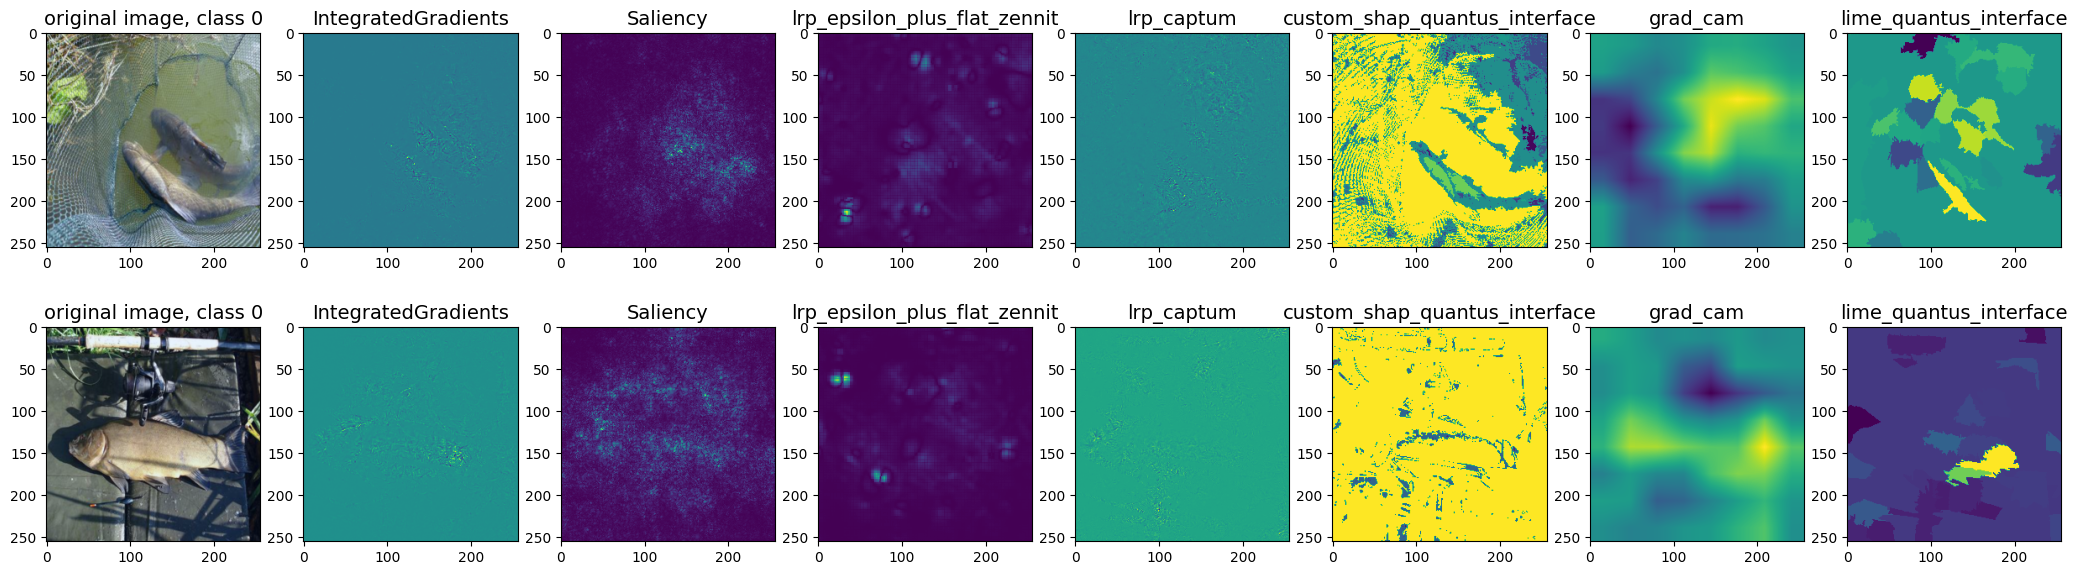

 10%|█         | 1/10 [01:35<14:23, 95.95s/it]

class 1: n02102040
number of images in class 1: 18


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([3, 256, 256]) tensor(1)
torch.Size([3, 256, 256]) tensor(1)


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:04<00:00,  5.24it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:05<00:00,  4.70it/s]


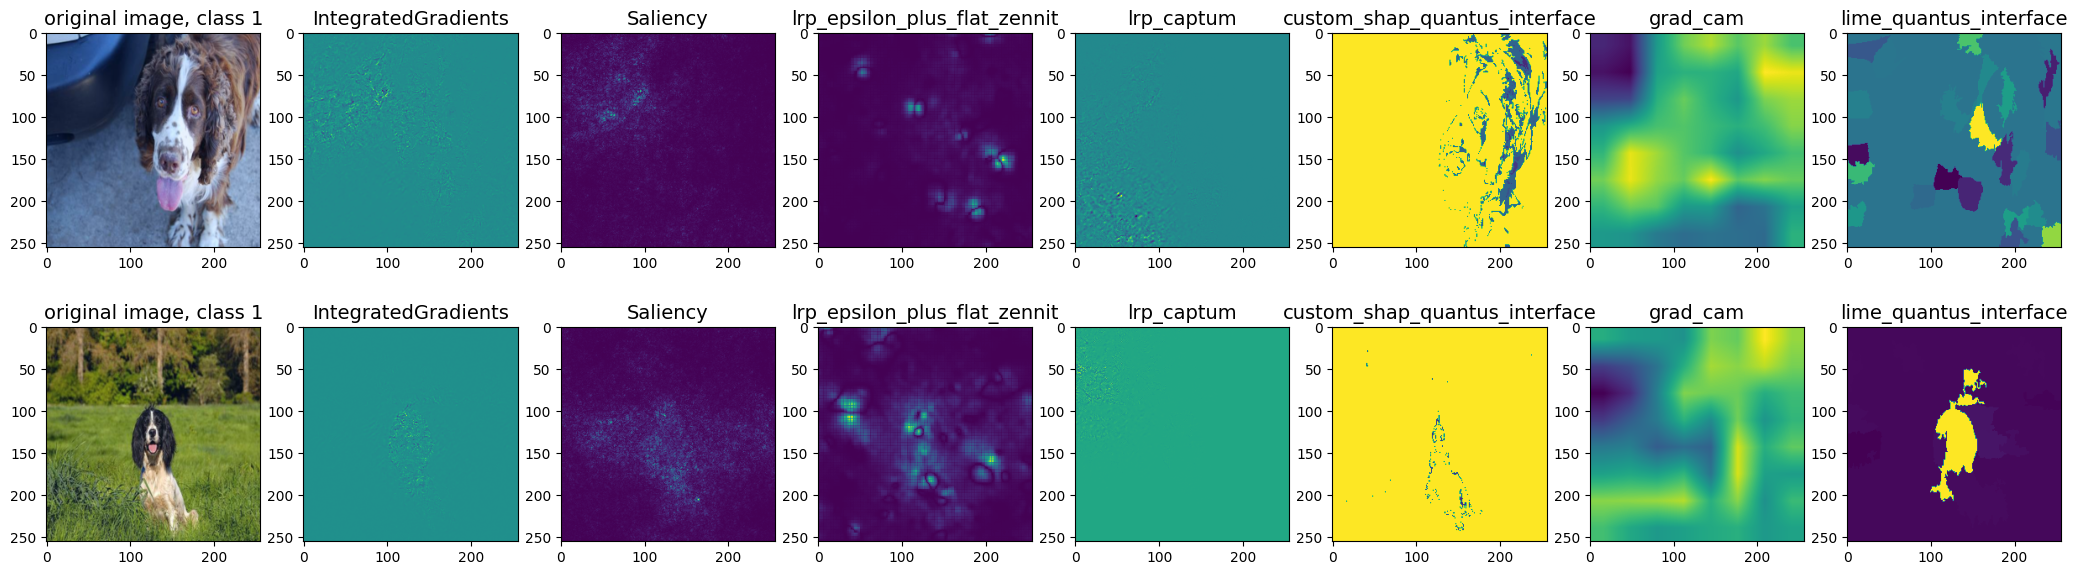

 20%|██        | 2/10 [03:29<14:11, 106.44s/it]

class 2: n02979186
number of images in class 2: 18


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([3, 256, 256]) tensor(2)
torch.Size([3, 256, 256]) tensor(2)


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:05<00:00,  4.78it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:04<00:00,  5.36it/s]


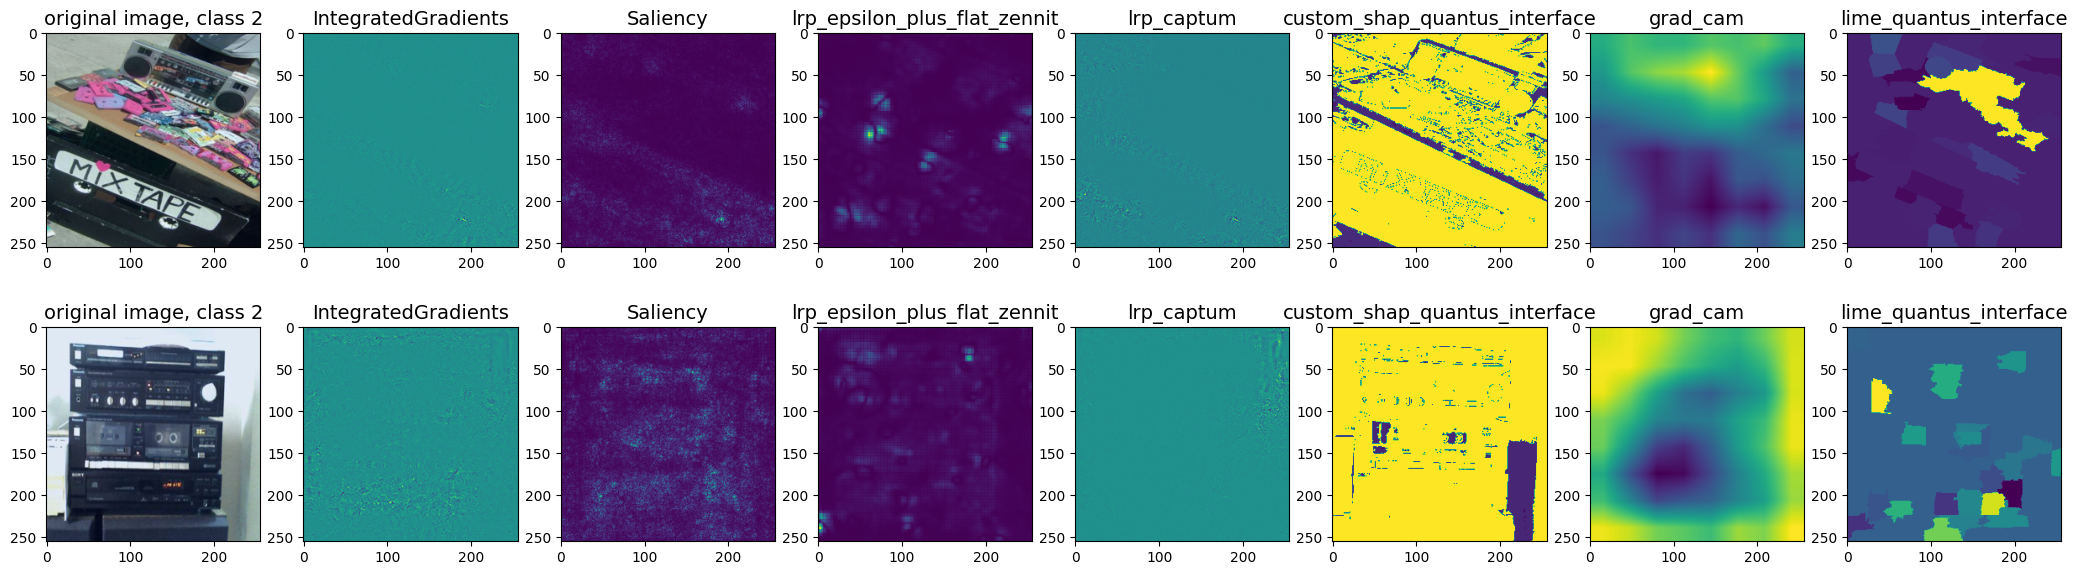

 30%|███       | 3/10 [05:11<12:11, 104.52s/it]

class 3: n03000684
number of images in class 3: 16


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([3, 256, 256]) tensor(3)
torch.Size([3, 256, 256]) tensor(3)


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:05<00:00,  4.95it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:04<00:00,  5.36it/s]


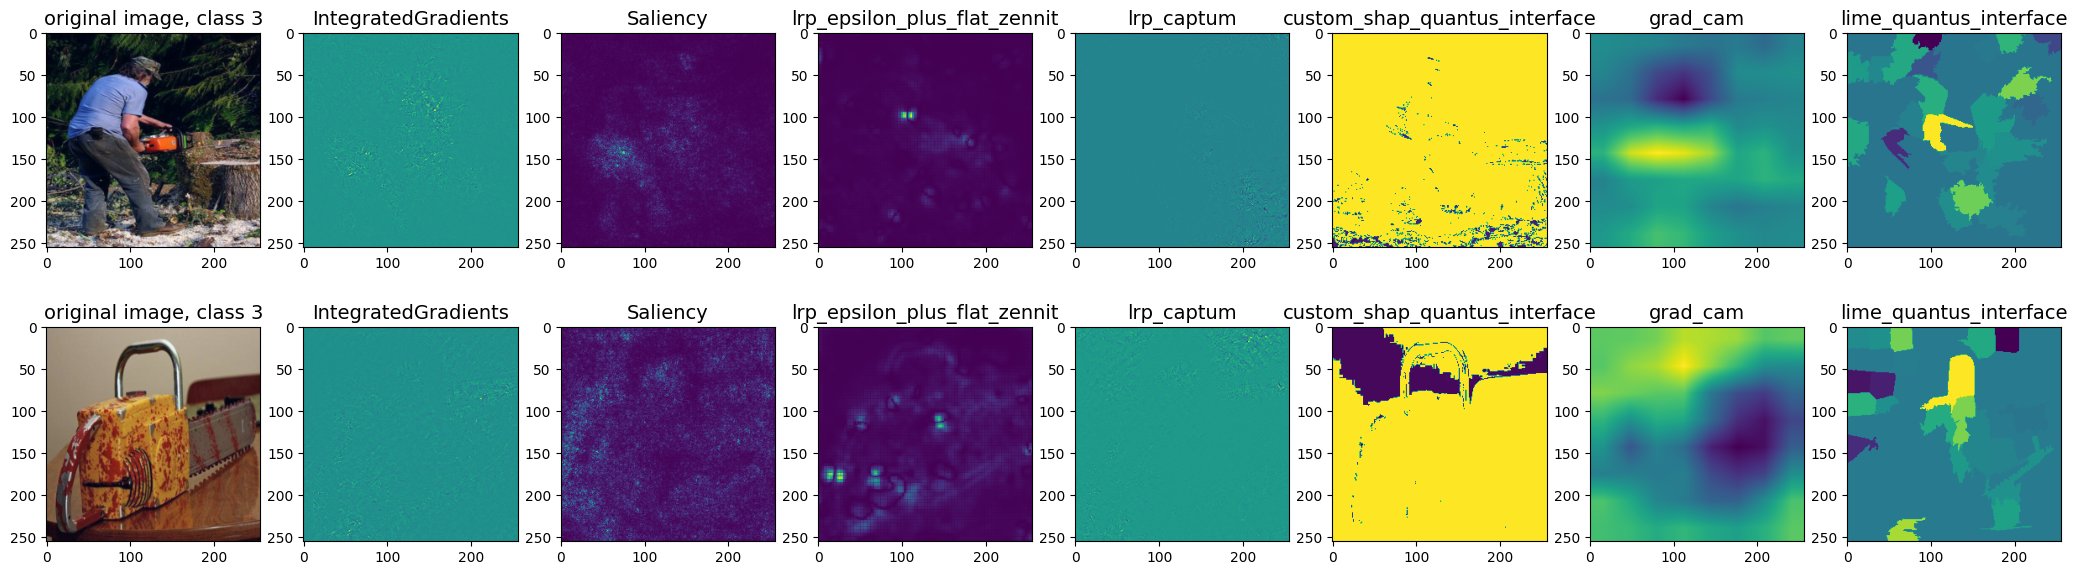

 40%|████      | 4/10 [06:51<10:16, 102.81s/it]


In [7]:
# attributions 
generated_attributions = {
    explanation_name : []
    for explanation_name in explanation_functions.keys()
}

for i in tqdm.tqdm(range(number_of_classes)):
    if i > MAX_NUM_OF_CLASSES_ANALYZED:
        break
    print(f"class {i}: {dataset.classes[i]}")
    classidx_to_leave = i
    filtered_dataset = torch.utils.data.Subset(dataset, np.arange(len(dataset.targets))[np.array(dataset.targets)==classidx_to_leave])
    print(f"number of images in class {i}: {len(filtered_dataset)}")
    data_loader = torch.utils.data.DataLoader(filtered_dataset, batch_size=BATCH_SIZE_PER_CLASS)
    batch_x, batch_y = next(iter(data_loader))
    
    attributions = get_attributions_for_batch(model, batch_x, batch_y)
    plot_attributions_for_batch(batch_x, batch_y, attributions)

    for explanation_name, explanation in attributions.items():
        generated_attributions[explanation_name].append(explanation)


## Metrics

In [29]:
results_all = {
    metric_name : {}
    for metric_name in metric_functions.keys()
}

In [10]:
metric_functions.keys()

dict_keys(['FaithfulnessEstimate', 'FaithfulnessCorrelation', 'MaxSensitivity', 'Complexity', 'RandomLogit', 'IterativeRemovalOfFeatures', 'AvgSensitivity', 'Sparseness'])

In [12]:
for metric_name, metric_function in metric_functions.items():
    print(f"-----------metric: {metric_name}---------------")

    results = {
        explanation_name : []
        for explanation_name in explanation_functions.keys()
    }

    for i in tqdm.tqdm(range(number_of_classes)):
        if i > MAX_NUM_OF_CLASSES_ANALYZED:
            break
        print(f"class {i}: {dataset.classes[i]}")
        classidx_to_leave = i
        filtered_dataset = torch.utils.data.Subset(dataset, np.arange(len(dataset.targets))[np.array(dataset.targets)==classidx_to_leave])
        print(f"number of images in class {i}: {len(filtered_dataset)}, analyzed: {BATCH_SIZE_PER_CLASS}")
        data_loader = torch.utils.data.DataLoader(filtered_dataset, batch_size=BATCH_SIZE_PER_CLASS)
        batch_x, batch_y = next(iter(data_loader))
        batch_x, batch_y = batch_x.numpy(), batch_y.numpy()

        for explanation_name, explanation in generated_attributions.items():
            results[explanation_name].extend(metric_function(
                 model=model, x_batch=batch_x, y_batch=batch_y, 
                a_batch=explanation[i],
                explain_func=explanation_functions[explanation_name]
            ))
    results_all[metric_name] = results

-----------metric: MaxSensitivity---------------


  0%|          | 0/10 [00:00<?, ?it/s]

class 0: n01440764
number of images in class 0: 14, analyzed: 2


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([3, 256, 256]) tensor(0)
torch.Size([3, 256, 256]) tensor(0)
torch.Size([3, 256, 256]) tensor(0)
torch.Size([3, 256, 256]) tensor(0)


 10%|█         | 1/10 [03:25<30:45, 205.02s/it]

class 1: n02102040
number of images in class 1: 18, analyzed: 2


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([3, 256, 256]) tensor(1)
torch.Size([3, 256, 256]) tensor(1)
torch.Size([3, 256, 256]) tensor(1)
torch.Size([3, 256, 256]) tensor(1)


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:04<00:00,  5.03it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:05<00:00,  4.89it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03106389944724841, tolerance: 0.0120596455109079
  model = cd_fast.enet_coordinate_descent(
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0,

class 2: n02979186
number of images in class 2: 18, analyzed: 2


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([3, 256, 256]) tensor(2)
torch.Size([3, 256, 256]) tensor(2)
torch.Size([3, 256, 256]) tensor(2)
torch.Size([3, 256, 256]) tensor(2)


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:05<00:00,  4.50it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:05<00:00,  4.81it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:05<00:00,  4.70it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
 30%|█

class 3: n03000684
number of images in class 3: 16, analyzed: 2


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([3, 256, 256]) tensor(3)
torch.Size([3, 256, 256]) tensor(3)
torch.Size([3, 256, 256]) tensor(3)
torch.Size([3, 256, 256]) tensor(3)


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:05<00:00,  4.66it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:05<00:00,  4.71it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
 40%|█

-----------metric: Complexity---------------


  0%|          | 0/10 [00:00<?, ?it/s]

class 0: n01440764
number of images in class 0: 14, analyzed: 2


 10%|█         | 1/10 [00:00<00:03,  2.92it/s]

class 1: n02102040
number of images in class 1: 18, analyzed: 2


 20%|██        | 2/10 [00:00<00:02,  2.95it/s]

class 2: n02979186
number of images in class 2: 18, analyzed: 2


 30%|███       | 3/10 [00:01<00:02,  2.97it/s]

class 3: n03000684
number of images in class 3: 16, analyzed: 2


 40%|████      | 4/10 [00:01<00:02,  2.93it/s]


-----------metric: RandomLogit---------------


  0%|          | 0/10 [00:00<?, ?it/s]

class 0: n01440764
number of images in class 0: 14, analyzed: 2


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([3, 256, 256]) tensor(0)
torch.Size([3, 256, 256]) tensor(0)


 10%|█         | 1/10 [01:43<15:31, 103.51s/it]

class 1: n02102040
number of images in class 1: 18, analyzed: 2


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([3, 256, 256]) tensor(1)
torch.Size([3, 256, 256]) tensor(1)


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:05<00:00,  4.74it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
 20%|██        | 2/10 [03:31<14:11, 106.38s/it]

class 2: n02979186
number of images in class 2: 18, analyzed: 2


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([3, 256, 256]) tensor(2)
torch.Size([3, 256, 256]) tensor(2)


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
 30%|███       | 3/10 [05:16<12:20, 105.77s/it]

class 3: n03000684
number of images in class 3: 16, analyzed: 2


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([3, 256, 256]) tensor(3)
torch.Size([3, 256, 256]) tensor(3)


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:05<00:00,  4.72it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
 40%|████      | 4/10 [07:02<10:34, 105.67s/it]


-----------metric: IterativeRemovalOfFeatures---------------


  0%|          | 0/10 [00:00<?, ?it/s]

class 0: n01440764
number of images in class 0: 14, analyzed: 2


 10%|█         | 1/10 [03:14<29:07, 194.12s/it]

class 1: n02102040
number of images in class 1: 18, analyzed: 2


 20%|██        | 2/10 [06:34<26:22, 197.86s/it]

class 2: n02979186
number of images in class 2: 18, analyzed: 2


 30%|███       | 3/10 [09:48<22:52, 196.14s/it]

class 3: n03000684
number of images in class 3: 16, analyzed: 2


 40%|████      | 4/10 [12:47<19:11, 191.90s/it]


-----------metric: AvgSensitivity---------------


  0%|          | 0/10 [00:00<?, ?it/s]

class 0: n01440764
number of images in class 0: 14, analyzed: 2


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([3, 256, 256]) tensor(0)
torch.Size([3, 256, 256]) tensor(0)
torch.Size([3, 256, 256]) tensor(0)
torch.Size([3, 256, 256]) tensor(0)


 10%|█         | 1/10 [03:09<28:26, 189.56s/it]

class 1: n02102040
number of images in class 1: 18, analyzed: 2


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([3, 256, 256]) tensor(1)
torch.Size([3, 256, 256]) tensor(1)
torch.Size([3, 256, 256]) tensor(1)
torch.Size([3, 256, 256]) tensor(1)


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:04<00:00,  5.38it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:04<00:00,  5.42it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03106389944724841, tolerance: 0.0120596455109079
  model = cd_fast.enet_coordinate_descent(
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0,

class 2: n02979186
number of images in class 2: 18, analyzed: 2


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([3, 256, 256]) tensor(2)
torch.Size([3, 256, 256]) tensor(2)
torch.Size([3, 256, 256]) tensor(2)
torch.Size([3, 256, 256]) tensor(2)


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:04<00:00,  5.41it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:04<00:00,  5.42it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:04<00:00,  5.40it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
 30%|█

class 3: n03000684
number of images in class 3: 16, analyzed: 2


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([3, 256, 256]) tensor(3)
torch.Size([3, 256, 256]) tensor(3)
torch.Size([3, 256, 256]) tensor(3)
torch.Size([3, 256, 256]) tensor(3)


t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:04<00:00,  5.31it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:04<00:00,  5.36it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
Lime attribution: 100%|██████████| 25/25 [00:04<00:00,  5.28it/s]
t:\studies\py_projects\bsc\lazy-explain\.venv\lib\site-packages\captum\attr\_core\lime.py:664: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn(
 40%|█

-----------metric: Sparseness---------------


  0%|          | 0/10 [00:00<?, ?it/s]

class 0: n01440764
number of images in class 0: 14, analyzed: 2


 10%|█         | 1/10 [00:00<00:03,  2.92it/s]

class 1: n02102040
number of images in class 1: 18, analyzed: 2


 20%|██        | 2/10 [00:00<00:02,  2.91it/s]

class 2: n02979186
number of images in class 2: 18, analyzed: 2


 30%|███       | 3/10 [00:01<00:02,  2.94it/s]

class 3: n03000684
number of images in class 3: 16, analyzed: 2


 40%|████      | 4/10 [00:01<00:02,  2.96it/s]


In [13]:
import pickle
with open(f"results_{DATASET}.pkl", "wb") as handle:
    pickle.dump(results_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
import pickle
with open(f"results_{DATASET}.pkl", 'rb') as handle:
    results_all = pickle.load(handle)

## Plots

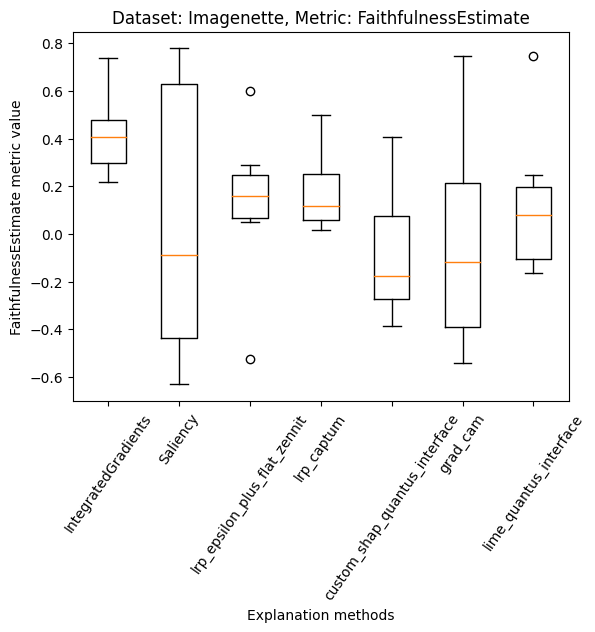

Mean values:
IntegratedGradients: 0.41783
Saliency: 0.04955
lrp_epsilon_plus_flat_zennit: 0.13032
lrp_captum: 0.18582
custom_shap_quantus_interface: -0.07399
grad_cam: -0.0314
lime_quantus_interface: 0.11796


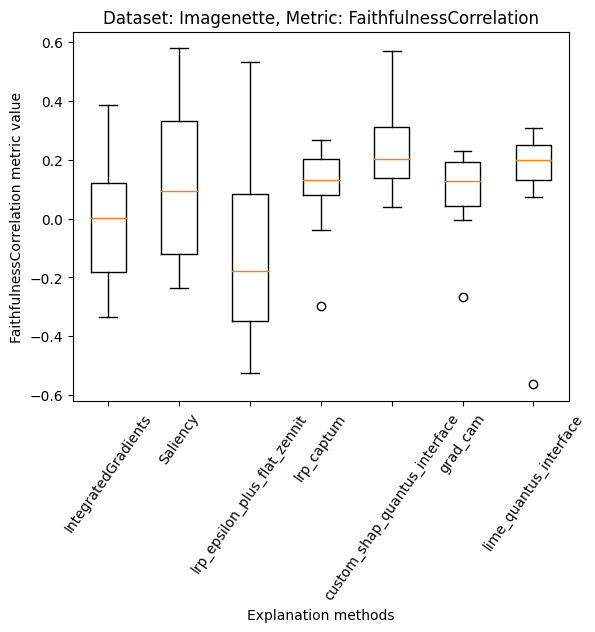

Mean values:
IntegratedGradients: -0.00326
Saliency: 0.13462
lrp_epsilon_plus_flat_zennit: -0.11375
lrp_captum: 0.09478
custom_shap_quantus_interface: 0.24244
grad_cam: 0.08372
lime_quantus_interface: 0.11114


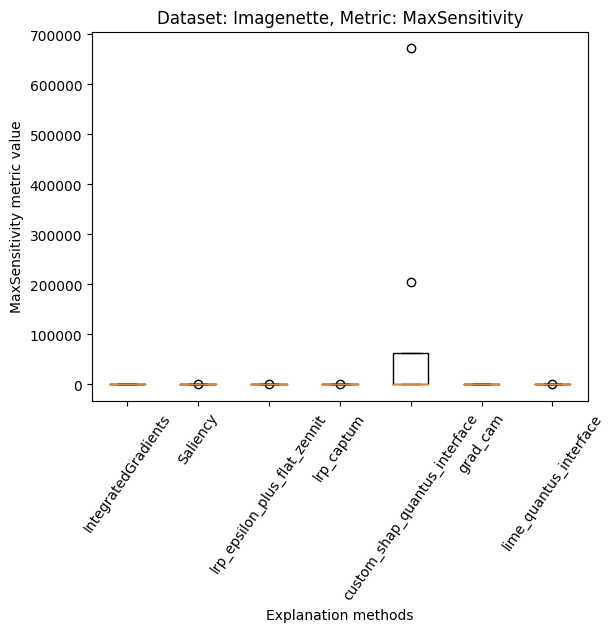

Mean values:
IntegratedGradients: 0.02196
Saliency: 0.02239
lrp_epsilon_plus_flat_zennit: 8e-05
lrp_captum: 0.44886
custom_shap_quantus_interface: 111638.9375
grad_cam: 0.00204
lime_quantus_interface: 0.38942


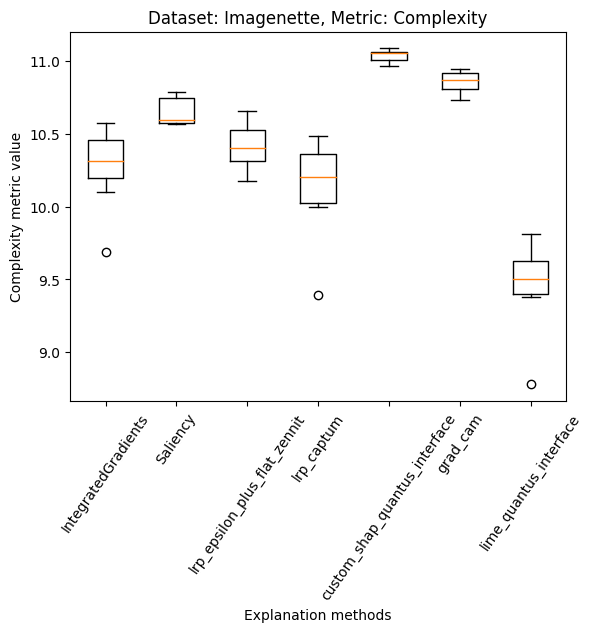

Mean values:
IntegratedGradients: 10.27548
Saliency: 10.6526
lrp_epsilon_plus_flat_zennit: 10.41228
lrp_captum: 10.13505
custom_shap_quantus_interface: 11.03694
grad_cam: 10.85908
lime_quantus_interface: 9.46374


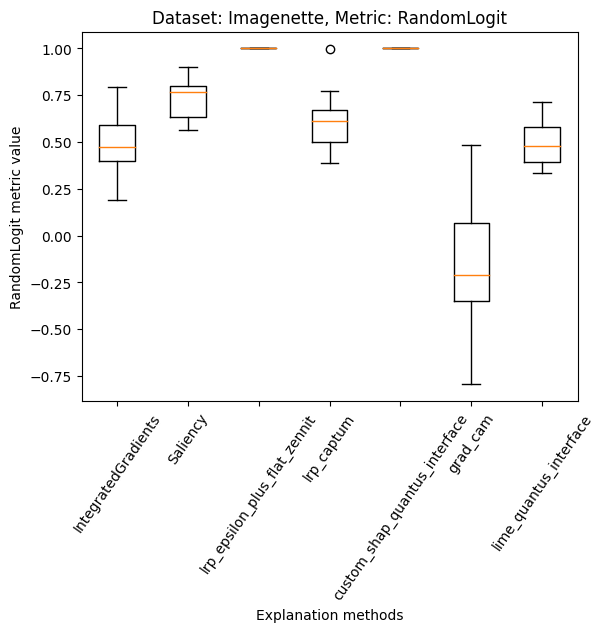

Mean values:
IntegratedGradients: 0.48419
Saliency: 0.73178
lrp_epsilon_plus_flat_zennit: 1.0
lrp_captum: 0.62655
custom_shap_quantus_interface: 1.0
grad_cam: -0.17067
lime_quantus_interface: 0.49144


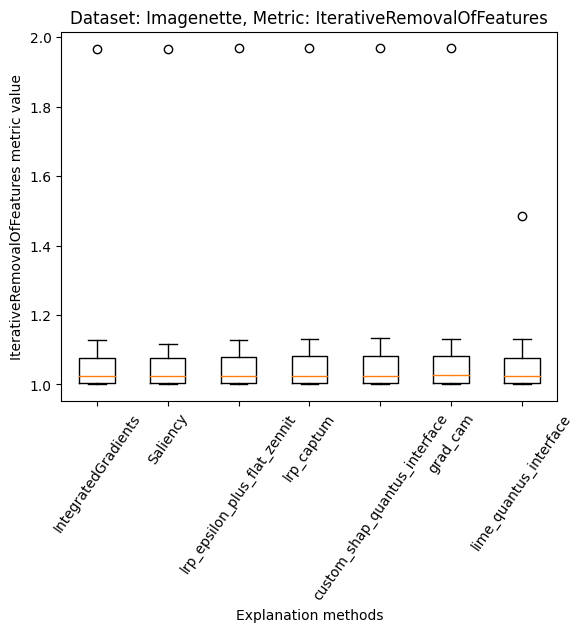

Mean values:
IntegratedGradients: 1.15148
Saliency: 1.15075
lrp_epsilon_plus_flat_zennit: 1.15212
lrp_captum: 1.15261
custom_shap_quantus_interface: 1.15258
grad_cam: 1.15284
lime_quantus_interface: 1.09173


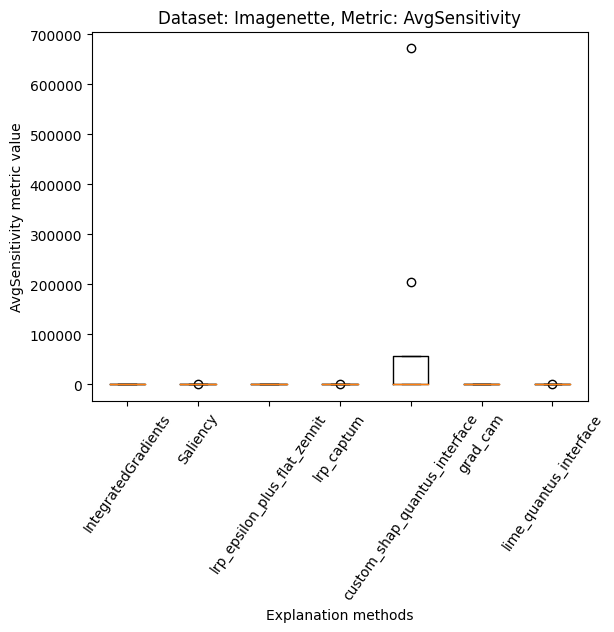

Mean values:
IntegratedGradients: 0.02177
Saliency: 0.02226
lrp_epsilon_plus_flat_zennit: 5e-05
lrp_captum: 0.41306
custom_shap_quantus_interface: 110610.66005
grad_cam: 0.00174
lime_quantus_interface: 0.37221


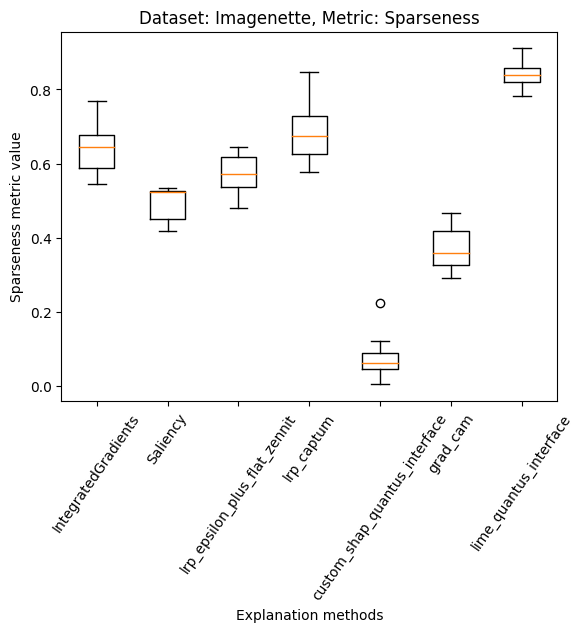

Mean values:
IntegratedGradients: 0.64025
Saliency: 0.49221
lrp_epsilon_plus_flat_zennit: 0.57104
lrp_captum: 0.68394
custom_shap_quantus_interface: 0.0796
grad_cam: 0.36946
lime_quantus_interface: 0.83962


In [15]:
for metric_name, results in results_all.items():
    fig, ax = plt.subplots()
    ax.boxplot(list(results.values()), showfliers=True)
    plt.xticks([i+1 for i in range(len(results))], results.keys(),rotation=55)
    ax.set_xlabel("Explanation methods")
    ax.set_ylabel(f"{metric_name} metric value")
    plt.title(f'Dataset: {DATASET}, Metric: {metric_name}')
    plt.show()

    print("Mean values:")
    for key, value in results.items():
        print(f"{key}: {round(float(np.mean(value)),5)}")

In [6]:
import pandas as pd
df = pd.DataFrame.from_dict(results_all)
df.to_csv(f"results_{DATASET}_nested_df.csv")
df


FaithfulnessEstimate  \
IntegratedGradients            [0.4019404135351284, 0.4148357850427057, 0.299...   
Saliency                       [0.7781292378913414, 0.6913657265291282, -0.32...   
lrp_epsilon_plus_flat_zennit   [0.21619384800415908, 0.04860134672809574, 0.2...   
lrp_captum                     [0.4579580522921158, 0.18080609253733854, 0.01...   
custom_shap_quantus_interface  [0.3580277524442871, -0.20868688226478296, -0....   
grad_cam                       [0.48931192485780894, 0.7444720540368084, -0.0...   
lime_quantus_interface         [0.13728848357628243, 0.24521721850645922, 0.1...   

                                                         FaithfulnessCorrelation  \
IntegratedGradients            [0.3861155381154657, -0.2587547077629301, 0.07...   
Saliency                       [0.5790950606923754, 0.25666505040690324, -0.1...   
lrp_epsilon_plus_flat_zennit   [-0.3184101966782054, 0.5327022103679496, -0.5...   
lrp_captum                     [0.12359508732696783, -0.2988991154093869, -0....   
custom_shap_quantus_interface  [0.3489805985959912, 0.14341379350348596, 0.30...   
grad_cam                       [0.11825833418276882, -0.2654529216241619, 0.2...   
lime_quantus_interface         [0.23814104204039038, 0.2844907234364819, 0.07...   

                                                                  MaxSensitivity  \
IntegratedGradients            [0.030162018, 0.030667024, 0.01743633, 0.01976...   
Saliency                       [0.05805653, 0.017018428, 0.022396987, 0.00842...   
lrp_epsilon_plus_flat_zennit   [0.00018356403, 4.4764216e-05, 7.0781396e-05, ...   
lrp_captum                     [0.08122789, 0.10105986, 0.32469591, 1.6178575...   
custom_shap_quantus_interface  [0.29990044, 204677.02, 16451.58, 0.46932915, ...   
grad_cam                       [0.003794721, 0.0013869879, 0.0023107475, 0.00...   
lime_quantus_interface         [0.32797542, 0.22637482, 0.28858954, 1.0770506...   

                                                                      Complexity  \
IntegratedGradients            [10.100881807027378, 10.229578811756452, 10.31...   
Saliency                       [10.568374651993828, 10.735077876825601, 10.57...   
lrp_epsilon_plus_flat_zennit   [10.654744134170294, 10.397548530460494, 10.17...   
lrp_captum                     [10.42282858952613, 10.341191834983647, 10.030...   
custom_shap_quantus_interface  [10.966423302304381, 11.06127858417945, 11.053...   
grad_cam                       [10.900936323988688, 10.810727870050503, 10.90...   
lime_quantus_interface         [9.726924174509122, 9.455131026840833, 9.37821...   

                                                                     RandomLogit  \
IntegratedGradients            [0.5885472517362008, 0.4473946816816634, 0.414...   
Saliency                       [0.7433009108029912, 0.6217002637079414, 0.788...   
lrp_epsilon_plus_flat_zennit   [1.0000000019801512, 1.000000001208829, 1.0000...   
lrp_captum                     [0.49157301198899656, 0.5027422622229687, 0.63...   
custom_shap_quantus_interface           [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]   
grad_cam                       [-0.11708653664457688, 0.055033674814570714, -...   
lime_quantus_interface         [0.4047243157189288, 0.4534026408276812, 0.598...   

                                                      IterativeRemovalOfFeatures  \
IntegratedGradients            [1.1292126564222542, 1.0592348080742937, 1.030...   
Saliency                       [1.117739571546096, 1.0628688625929996, 1.0308...   
lrp_epsilon_plus_flat_zennit   [1.126611967586939, 1.064315613163572, 1.03163...   
lrp_captum                     [1.1300746734156775, 1.0645064974380318, 1.031...   
custom_shap_quantus_interface  [1.1323478215369533, 1.0636343995729831, 1.029...   
grad_cam                       [1.1305228192784256, 1.0639992138970769, 1.032...   
lime_quantus_interface         [1.1320334518989625, 1.0592348080742937, 1.031...   

                      

In [8]:
import pandas as pd
df2 = pd.DataFrame({
    (metric_name, explanation_name): results[explanation_name]
    for metric_name, results in results_all.items()
    for explanation_name in results.keys()
})
df2.to_csv(f"results_{DATASET}_flat_df.csv")
df2

FaithfulnessEstimate                                                    \
   IntegratedGradients  Saliency lrp_epsilon_plus_flat_zennit lrp_captum   
0             0.401940  0.778129                     0.216194   0.457958   
1             0.414836  0.691366                     0.048601   0.180806   
2             0.299476 -0.320073                     0.288037   0.015099   
3             0.517587  0.610325                     0.599886   0.037579   
4             0.217091 -0.442648                     0.103672   0.153099   
5             0.290053 -0.631860                    -0.523916   0.064986   
6             0.462919 -0.434446                     0.074709   0.080331   
7             0.738714  0.145629                     0.235351   0.496702   

                                                                  \
  custom_shap_quantus_interface  grad_cam lime_quantus_interface   
0                      0.358028  0.489312               0.137288   
1                     -0.208687  0.744472               0.245217   
2                     -0.384984 -0.029139               0.178842   
3                     -0.348371 -0.367315               0.747743   
4                     -0.019179 -0.542502              -0.123342   
5                     -0.248365  0.123960               0.020561   
6                     -0.146577 -0.208772              -0.165726   
7                      0.406211 -0.461228              -0.096932   

  FaithfulnessCorrelation                                         ...  \
      IntegratedGradients  Saliency lrp_epsilon_plus_flat_zennit  ...   
0                0.386116  0.579095                    -0.318410  ...   
1               -0.258755  0.256665                     0.532702  ...   
2                0.076375 -0.106398                    -0.525083  ...   
3                0.259332 -0.167511                     0.138750  ...   
4               -0.335217  0.143052                     0.064151  ...   
5               -0.002392  0.558364                    -0.131535  ...   
6                0.006348 -0.234558                    -0.226022  ...   
7               -0.157924  0.048273                    -0.444531  ...   

                 AvgSensitivity                                   \
  custom_shap_quantus_interface  grad_cam lime_quantus_interface   
0                      0.318688  0.002728               0.320899   
1                 204677.015625  0.001289               0.218829   
2                   8226.140625  0.001934               0.271448   
3                      0.469329  0.000994               1.047661   
4                      1.930639  0.002071               0.445495   
5                 671974.562500  0.000550               0.228769   
6                      0.605274  0.000762               0.245598   
7                      4.237699  0.003567               0.198979   

           Sparseness                                                    \
  IntegratedGradients  Saliency lrp_epsilon_plus_flat_zennit lrp_captum   
0            0.701102  0.534585                     0.479128   0.606233   
1            0.670769  0.457823                     0.573216   0.634257   
2            0.646924  0.526373                     0.645576   0.734002   
3            0.769379  0.527214                     0.609187   0.845908   
4            0.641457  0.524309                     0.638633   0.680573   
5            0.543763  0.424730                     0.506476   0.667779   
6            0.603111  0.523528                     0.570372   0.725510   
7            0.545498  0.419077                     0.545769   0.577275   

                                                                  
  custom_shap_quantus_interface  grad_cam lime_quantus_interface  
0                      0.223749  0.336815               0.802078  
1                      0.048507  0.413426               0.849316  
2                      0.057741  0.332006               0.860786  
3                      0.004301  0.428179               0.9107